<a href="https://colab.research.google.com/github/choazephyr/final_project_6610505489_6610505551/blob/main/final_project_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hand gesture

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from pathlib import Path

DATA_ROOT = Path("/content/drive/MyDrive/hagrid-sample-30k-384p")
assert DATA_ROOT.exists(), f"ไม่พบโฟลเดอร์: {DATA_ROOT}"
print("DATA_ROOT =", DATA_ROOT)


DATA_ROOT = /content/drive/MyDrive/hagrid-sample-30k-384p


In [ ]:
classes = sorted([p for p in DATA_ROOT.iterdir() if p.is_dir()])
print("พบคลาส:", [c.name for c in classes][:20], "… (รวม", len(classes), ")")


พบคลาส: ['ann_train_val', 'hagrid_30k', 'splits_801010_drive'] … (รวม 3 )


In [ ]:
from pathlib import Path

DATA_ROOT = Path("/content/drive/MyDrive/hagrid-sample-30k-384p")
IMG_ROOT  = DATA_ROOT / "hagrid_30k"
assert IMG_ROOT.exists(), IMG_ROOT
subs = sorted([p for p in IMG_ROOT.iterdir() if p.is_dir()])
print("inside hagrid_30k:", [s.name for s in subs][:20], "… (", len(subs), ")")


inside hagrid_30k: ['train_val_dislike', 'train_val_fist', 'train_val_like', 'train_val_ok', 'train_val_palm', 'train_val_peace'] … ( 6 )


In [ ]:
# === CONFIG ===
from pathlib import Path
import os, random, shutil

# โฟลเดอร์ใน Drive ที่มี hagrid_30k อยู่ข้างใน (แก้ให้ตรงของคุณ)
DATA_ROOT = Path("/content/drive/MyDrive/hagrid-sample-30k-384p")
IMG_ROOT  = DATA_ROOT / "hagrid_30k"

# โฟลเดอร์ผลลัพธ์ (อยู่บนเครื่อง จะเร็วกว่า)
OUT_ROOT = Path("/content/splits")

# โหมดวางไฟล์: "symlink" | "copy" | "move"
MODE = "symlink"

# ถ้าอยากเลือกเฉพาะ 6 คลาสยอดฮิต ให้ตั้ง True
ONLY_TOP6 = True
TOP6 = {"like","dislike","fist","palm","peace","ok","okay"}  # ok/okay นับเป็นคลาสเดียวตามชื่อโฟลเดอร์ที่มี

# สุ่มซ้ำได้
SEED = 42
random.seed(SEED)

# นามสกุลรูปที่รองรับ
EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".webp"}

TEST = 0.20         # 20% ของทั้งหมดเป็น test
VAL_OF_TEST = 0.50  # 50% ของ test ย้ายไปเป็น val  -> val = 10% ของทั้งหมด

# === UTIL ===
def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def place_file(src: Path, dst: Path):
    """วางไฟล์ตาม MODE พร้อมกันชื่อซ้ำ"""
    ensure_dir(dst.parent)
    if dst.exists():
        stem, ext = dst.stem, dst.suffix
        k = 1
        while True:
            alt = dst.with_name(f"{stem}_{k}{ext}")
            if not alt.exists():
                dst = alt; break
            k += 1
    if MODE == "symlink":
        try:
            if dst.exists(): dst.unlink()
            os.symlink(src, dst)
        except Exception:
            shutil.copy2(src, dst)  # fallback
    elif MODE == "copy":
        shutil.copy2(src, dst)
    elif MODE == "move":
        shutil.move(str(src), str(dst))
    else:
        raise ValueError("MODE must be 'symlink' | 'copy' | 'move'")

def gather_class_dirs(img_root: Path):
    """คืน {class_name: Path_to_dir} รองรับทั้งโครงสร้าง class/ และ train_val_*"""
    subs = sorted([p for p in img_root.iterdir() if p.is_dir()], key=lambda p: p.name)
    # ตรวจถ้าเป็นรูปแบบ train_val_<class>
    tv_dirs = [d for d in subs if d.name.startswith("train_val_")]
    if tv_dirs:
        # รวมไฟล์จาก train_val_<class> มาวางเป็นโฟลเดอร์คลาสเดียว (ใช้ symlink/copy)
        PREP = Path("/content/prepared_classes")
        ensure_dir(PREP)
        class_map = {}
        for d in tv_dirs:
            cls = d.name[len("train_val_"):] or d.name
            class_map.setdefault(cls, PREP / cls)
            ensure_dir(class_map[cls])
            for f in d.rglob("*"):
                if f.is_file() and f.suffix.lower() in EXTS:
                    dst = class_map[cls] / f.name
                    # ใช้ symlink/copy ตรงนี้เสมอ (move ไม่เหมาะ เพราะเป็น data ต้นฉบับ)
                    try:
                        if dst.exists(): dst.unlink()
                        os.symlink(f, dst)
                    except Exception:
                        shutil.copy2(f, dst)
        return class_map
    else:
        # โครงสร้าง class_name/ ตรง ๆ
        class_map = {d.name: d for d in subs}
        return class_map

def split_one_class(cls_name: str, cls_dir: Path, out_root: Path):
    files = [p for p in cls_dir.rglob("*") if p.is_file() and p.suffix.lower() in EXTS]
    if not files:
        print(f"[{cls_name}] ไม่มีไฟล์ -> ข้าม")
        return (0,0,0)
    random.shuffle(files)

    n = len(files)
    n_test = int(round(n * TEST))
    test_pool = files[:n_test]
    remain_for_train = files[n_test:]

    n_val = int(round(len(test_pool) * VAL_OF_TEST))
    val_set  = test_pool[:n_val]
    test_set = test_pool[n_val:]
    train_set = remain_for_train

    for split in ("train","val","test"):
        ensure_dir(out_root / split / cls_name)

    for f in train_set:
        place_file(f, out_root / "train" / cls_name / f.name)
    for f in val_set:
        place_file(f, out_root / "val" / cls_name / f.name)
    for f in test_set:
        place_file(f, out_root / "test" / cls_name / f.name)

    print(f"[{cls_name}] total={n} -> train={len(train_set)}, val={len(val_set)}, test={len(test_set)}")
    return (len(train_set), len(val_set), len(test_set))


# === MAIN ===
assert IMG_ROOT.exists(), f"ไม่พบโฟลเดอร์ภาพ: {IMG_ROOT}"
print("Using:", IMG_ROOT)

class_map = gather_class_dirs(IMG_ROOT)  # {class_name: path}
classes = sorted(class_map.keys())

if ONLY_TOP6:
    classes = [c for c in classes if c in TOP6]
    if not classes:
        print("ไม่พบคลาสที่อยู่ใน TOP6 ในโครงสร้างนี้ — จะใช้ทุกคลาสแทน")
        classes = sorted(class_map.keys())

print("Classes to use:", classes)

ensure_dir(OUT_ROOT)
tot_tr = tot_va = tot_te = 0
for cls in classes:
    tr, va, te = split_one_class(cls, class_map[cls], OUT_ROOT)
    tot_tr += tr; tot_va += va; tot_te += te

total = tot_tr + tot_va + tot_te
print("\n=== SUMMARY ===")
print("train =", tot_tr, "val =", tot_va, "test =", tot_te, "total =", total)
if total > 0:
    print("ratios: train {:.3f}, val {:.3f}, test {:.3f}".format(
        tot_tr/total, tot_va/total, tot_te/total
    ))
print("Output at:", OUT_ROOT)


Using: /content/drive/MyDrive/hagrid-sample-30k-384p/hagrid_30k
Classes to use: ['dislike', 'fist', 'like', 'ok', 'palm', 'peace']
[dislike] total=1783 -> train=1426, val=178, test=179
[fist] total=1738 -> train=1390, val=174, test=174
[like] total=1732 -> train=1386, val=173, test=173
[ok] total=1777 -> train=1422, val=178, test=177
[palm] total=1770 -> train=1416, val=177, test=177
[peace] total=1769 -> train=1415, val=177, test=177

=== SUMMARY ===
train = 8455 val = 1057 test = 1057 total = 10569
ratios: train 0.800, val 0.100, test 0.100
Output at: /content/splits


In [ ]:
from pathlib import Path
import os, random, shutil

IMG_ROOT = Path("/content/drive/MyDrive/hagrid-sample-30k-384p/hagrid_30k")
OUT_DRIVE = Path("/content/drive/MyDrive/hagrid-sample-30k-384p/splits_801010_drive")
EXTS = {".jpg",".jpeg",".png",".bmp",".gif",".webp"}
random.seed(42)

def ensure(p): p.mkdir(parents=True, exist_ok=True)

def copy_safe(src: Path, dst: Path):
    ensure(dst.parent)
    if dst.exists():
        stem, ext = dst.stem, dst.suffix
        k = 1
        while (dst := dst.with_name(f"{stem}_{k}{ext}")).exists(): k += 1
    shutil.copy2(src, dst)

ensure(OUT_DRIVE)
for cls_dir in sorted([d for d in IMG_ROOT.iterdir() if d.is_dir()]):
    files = [p for p in cls_dir.rglob("*") if p.is_file() and p.suffix.lower() in EXTS]
    random.shuffle(files)
    n = len(files)
    n_test = int(round(n*0.10))
    n_val  = int(round(n*0.10))
    te = files[:n_test]
    va = files[n_test:n_test+n_val]
    tr = files[n_test+n_val:]

    for f in tr: copy_safe(f, OUT_DRIVE/"train"/cls_dir.name/f.name)
    for f in va: copy_safe(f, OUT_DRIVE/"val"/cls_dir.name/f.name)
    for f in te: copy_safe(f, OUT_DRIVE/"test"/cls_dir.name/f.name)
    print(f"[{cls_dir.name}] train={len(tr)}, val={len(va)}, test={len(te)}")

print("Persistent splits at:", OUT_DRIVE)


[train_val_dislike] train=1427, val=178, test=178
[train_val_fist] train=1390, val=174, test=174
[train_val_like] train=1386, val=173, test=173
[train_val_ok] train=1421, val=178, test=178
[train_val_palm] train=1416, val=177, test=177
[train_val_peace] train=1415, val=177, test=177
Persistent splits at: /content/drive/MyDrive/hagrid-sample-30k-384p/splits_801010_drive


In [ ]:
from pathlib import Path
import random, os

ROOT = Path("/content/splits")  # โฟลเดอร์สปลิตที่ใช้อยู่ตอนนี้
samples = []

for split in ["train","val","test"]:
    cls_dirs = [d for d in (ROOT/split).iterdir() if d.is_dir()]
    for _ in range(3):
        c = random.choice(cls_dirs)
        img = random.choice([p for p in c.rglob("*") if p.suffix.lower() in [".jpg",".jpeg",".png"]])
        samples.append(img)

for p in samples:
    real = p.resolve()
    print("path:", p)
    print("  is_symlink:", p.is_symlink())
    print("  realpath :", real)
    print("  on_drive :", str(real).startswith("/content/drive/"))


path: /content/splits/train/like/6ac4de17-0732-46f4-9955-bd30b9b7fa4f.jpg
  is_symlink: True
  realpath : /content/drive/.shortcut-targets-by-id/1nvfDKXeNKSvFZATc2FaPHI51bJ6OeRR2/hagrid-sample-30k-384p/hagrid_30k/train_val_like/6ac4de17-0732-46f4-9955-bd30b9b7fa4f.jpg
  on_drive : True
path: /content/splits/train/dislike/a99371f2-2178-4e00-9362-7ae7d5285bb3.jpg
  is_symlink: True
  realpath : /content/drive/.shortcut-targets-by-id/1nvfDKXeNKSvFZATc2FaPHI51bJ6OeRR2/hagrid-sample-30k-384p/hagrid_30k/train_val_dislike/a99371f2-2178-4e00-9362-7ae7d5285bb3.jpg
  on_drive : True
path: /content/splits/train/like/661ca03b-0fbd-428c-b01b-7d8da9d1e67e.jpg
  is_symlink: True
  realpath : /content/drive/.shortcut-targets-by-id/1nvfDKXeNKSvFZATc2FaPHI51bJ6OeRR2/hagrid-sample-30k-384p/hagrid_30k/train_val_like/661ca03b-0fbd-428c-b01b-7d8da9d1e67e.jpg
  on_drive : True
path: /content/splits/val/ok/5922e2b8-b791-41af-92d4-d2708c5c2654.jpg
  is_symlink: True
  realpath : /content/drive/.shortcut-target

In [ ]:
# คัดลอกสปลิตทั้งชุด (ตาม symlink ไปเอาไฟล์จริง) มาไว้โลคัล
!mkdir -p /content/splits_local
!rsync -aL --info=progress2 "/content/splits/" "/content/splits_local/"

# เช็กขนาดรวม (ควรเยอะขึ้น = ไม่ใช่แค่ symlink)
!du -sh /content/splits_local


    270,468,516 100%    7.74MB/s    0:00:33 (xfr#10569, to-chk=0/10591)
280M	/content/splits_local


In [ ]:
from pathlib import Path
DATA_ROOT = Path("/content/splits_local")  # แทน /content/splits เดิม


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

USE_GPU = torch.cuda.is_available()
IMG = 224

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
eval_tf  = transforms.Compose([
    transforms.Resize((IMG, IMG)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

train_ds = datasets.ImageFolder(str(DATA_ROOT/"train"), transform=train_tf)
val_ds   = datasets.ImageFolder(str(DATA_ROOT/"val"),   transform=eval_tf)

NUM_WORKERS = 4 if USE_GPU else 0
PIN_MEMORY  = True if USE_GPU else False
PERSISTENT  = True if USE_GPU else False
PREFETCH    = 2 if USE_GPU else None

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT, prefetch_factor=PREFETCH)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT, prefetch_factor=PREFETCH)

torch.backends.cudnn.benchmark = True


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
from pathlib import Path
import random
ROOT = Path("/content/splits_local")
for split in ["train","val","test"]:
    cls_dirs = [d for d in (ROOT/split).iterdir() if d.is_dir()]
    for _ in range(2):
        c = random.choice(cls_dirs)
        p = random.choice([q for q in c.rglob("*") if q.suffix.lower() in [".jpg",".jpeg",".png"]])
        print("is_symlink:", p.is_symlink(), "| realpath startswith /content/drive?:", str(p.resolve()).startswith("/content/drive/"))


is_symlink: False | realpath startswith /content/drive?: False
is_symlink: False | realpath startswith /content/drive?: False
is_symlink: False | realpath startswith /content/drive?: False
is_symlink: False | realpath startswith /content/drive?: False
is_symlink: False | realpath startswith /content/drive?: False
is_symlink: False | realpath startswith /content/drive?: False


# ตั้งค่าโปรเจกต์และพารามิเตอร์ (Config)

In [ ]:
# =====================[ Cell 1: CONFIG ]=====================
from pathlib import Path
import os

DATA_ROOT       = Path("/content/splits_local")
OUT_DIR         = Path("/content/run_outputs")

SEED            = 42

IMG_SIZE        = 224
BATCH           = 32
EPOCHS          = 15
LR              = 3e-4
WEIGHT_DECAY    = 1e-4
USE_PRETRAINED  = True
FREEZE_EPOCHS   = 3
EARLY_PATIENCE  = 5
CLIP_NORM       = 1.0

# ใช้ค่าน้อยตามคำเตือนระบบ (หรือจะบังคับเป็น 2 ตายตัวก็ได้)
NUM_WORKERS     = min(2, os.cpu_count() if os.cpu_count() else 2)

DROP_P          = 0.2
MID_CH          = 256


# Import และ Utils พื้นฐาน
รวมไลบรารี, ฟังก์ชันอำนวยความสะดวก (ตั้ง seed, เลือก device, เซฟไฟล์)

In [ ]:
# =====================[ Cell 2: IMPORTS & UTILS ]=====================
import os, json, math, random, time
from typing import Tuple, Dict, List

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_recall_fscore_support
)
from tqdm.auto import tqdm

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True  # เร็วขึ้นบน GPU

def device_default():
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def makedirs(path: Path):
    path.mkdir(parents=True, exist_ok=True)

def save_json(obj, path: Path):
    with open(path, "w") as f:
        json.dump(obj, f, indent=2, ensure_ascii=False)

def save_txt(s: str, path: Path):
    with open(path, "w", encoding="utf-8") as f:
        f.write(s)


# Transforms และ DataLoader
นิยามการแปลงภาพ (augment/normalize) และสร้าง DataLoader ของ train/val/test

In [ ]:
# =====================[ Cell 3: DATA PIPELINE ]=====================
def build_transforms(img_size=224):
    mean = (0.485, 0.456, 0.406)
    std  = (0.229, 0.224, 0.225)

    train_tf = transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(0.1,0.1,0.1,0.05),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    eval_tf = transforms.Compose([
        transforms.Resize(int(img_size*1.15)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    return train_tf, eval_tf

def build_dataloaders(data_root: Path, img_size=224, batch_size=32, num_workers=4):
    train_tf, eval_tf = build_transforms(img_size)
    train_ds = datasets.ImageFolder(data_root/"train", transform=train_tf)
    val_ds   = datasets.ImageFolder(data_root/"val",   transform=eval_tf)
    test_ds  = datasets.ImageFolder(data_root/"test",  transform=eval_tf)

    classes = train_ds.classes
    dls = {
        "train": DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True, persistent_workers=True),
        "val":   DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True),
        "test":  DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True),
    }
    return dls, classes


# นิยามโมเดล “ออกแบบเอง”
เพิ่มคอมโพเนนต์ ConvBNAct, SEBlock, และหัวโมเดล GestureHead แล้วนำมาต่อกับ backbone ResNet18

In [ ]:
# =====================[ Cell 4: MODEL (Custom Head + SE) ]=====================
class ConvBNAct(nn.Module):
    def __init__(self, c_in, c_out, k=3, s=1, p=1, act=True):
        super().__init__()
        self.conv = nn.Conv2d(c_in, c_out, k, s, p, bias=False)
        self.bn   = nn.BatchNorm2d(c_out)
        self.act  = nn.ReLU(inplace=True) if act else nn.Identity()
    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class SEBlock(nn.Module):
    def __init__(self, ch, r=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc   = nn.Sequential(
            nn.Conv2d(ch, ch // r, 1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch // r, ch, 1, bias=True),
            nn.Sigmoid()
        )
    def forward(self, x):
        w = self.fc(self.pool(x))
        return x * w

class GestureHead(nn.Module):
    """Conv3x3 (512->MID_CH) + BN + ReLU + SE + GAP + Dropout + Linear"""
    def __init__(self, in_ch=512, mid_ch=256, num_classes=6, drop_p=0.2):
        super().__init__()
        self.neck = nn.Sequential(
            ConvBNAct(in_ch, mid_ch, k=3, s=1, p=1),
            SEBlock(mid_ch, r=16),
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.drop = nn.Dropout(p=drop_p)
        self.fc   = nn.Linear(mid_ch, num_classes)

        # init
        nn.init.kaiming_normal_(self.neck[0].conv.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.neck[0].bn.weight, 1.0)
        nn.init.constant_(self.neck[0].bn.bias, 0.0)
        nn.init.normal_(self.fc.weight, std=0.01)
        nn.init.constant_(self.fc.bias, 0.0)

    def forward(self, x):
        x = self.neck(x)            # (B, mid_ch, H, W)
        x = self.pool(x).flatten(1) # (B, mid_ch)
        x = self.drop(x)
        x = self.fc(x)
        return x

class GestureResNet18Custom(nn.Module):
    """Backbone: ResNet18 (conv1..layer4) -> Custom Head"""
    def __init__(self, num_classes, use_pretrained=True, mid_ch=256, drop_p=0.2):
        super().__init__()
        try:
            weights = models.ResNet18_Weights.DEFAULT if use_pretrained else None
        except AttributeError:
            weights = 'IMAGENET1K_V1' if use_pretrained else None

        base = models.resnet18(weights=weights)
        self.backbone = nn.Sequential(
            base.conv1, base.bn1, base.relu, base.maxpool,
            base.layer1, base.layer2, base.layer3, base.layer4
        )
        self.head = GestureHead(in_ch=512, mid_ch=mid_ch, num_classes=num_classes, drop_p=drop_p)

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

def build_model(num_classes: int, use_pretrained: bool = True, mid_ch: int = MID_CH, drop_p: float = DROP_P):
    return GestureResNet18Custom(num_classes=num_classes, use_pretrained=use_pretrained, mid_ch=mid_ch, drop_p=drop_p)

def set_backbone_trainable(model: nn.Module, trainable: bool = True):
    for p in model.backbone.parameters():
        p.requires_grad = trainable
    for p in model.head.parameters():
        p.requires_grad = True


# ฟังก์ชัน TRAIN/EVAL HELPERS


In [ ]:
# =====================[ Cell 5: TRAIN/EVAL HELPERS ]=====================
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import numpy as np

@torch.no_grad()
def run_eval(model, loader, device):
    model.eval()
    all_logits, all_targets = [], []
    for imgs, targets in loader:
        imgs = imgs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        logits = model(imgs)
        all_logits.append(logits.cpu()); all_targets.append(targets.cpu())
    logits = torch.cat(all_logits, 0)
    targets = torch.cat(all_targets, 0)
    preds = logits.argmax(1)
    acc = (preds == targets).float().mean().item()
    return acc, targets.numpy(), preds.numpy(), logits.numpy()

def run_epoch(model, loader, device, optimizer=None, scaler=None, clip_norm=0.0, train=True):
    loss_fn = nn.CrossEntropyLoss()
    model.train() if train else model.eval()
    running_loss, running_correct, running_total = 0.0, 0, 0
    it = tqdm(loader, leave=False, desc="train" if train else "eval")

    use_amp = (device.type == "cuda")

    for imgs, targets in it:
        imgs = imgs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        # ---- ใช้สไตล์ใหม่ (torch.amp.autocast) พร้อม fallback ----
        try:
            ctx = torch.amp.autocast("cuda", enabled=use_amp)
        except Exception:
            # fallback สำหรับ PyTorch รุ่นก่อน
            ctx = torch.cuda.amp.autocast(enabled=use_amp)

        with ctx:
            logits = model(imgs)
            loss = loss_fn(logits, targets)

        if train:
            optimizer.zero_grad(set_to_none=True)
            if scaler is not None and use_amp:
                scaler.scale(loss).backward()
                if clip_norm and clip_norm > 0:
                    scaler.unscale_(optimizer)
                    nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
                scaler.step(optimizer); scaler.update()
            else:
                loss.backward()
                if clip_norm and clip_norm > 0:
                    nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
                optimizer.step()

        with torch.no_grad():
            preds = logits.argmax(1)
            running_loss += loss.item() * imgs.size(0)
            running_correct += (preds == targets).sum().item()
            running_total += imgs.size(0)

        it.set_postfix(loss=running_loss/running_total, acc=running_correct/running_total)

    avg_loss = running_loss / running_total
    avg_acc  = running_correct / running_total
    return avg_loss, avg_acc


def plot_curves(hist, out_dir):
    import matplotlib.pyplot as plt
    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(hist["train_loss"], label="train")
    plt.plot(hist["val_loss"],   label="val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curve"); plt.legend()
    plt.tight_layout(); plt.savefig(out_dir/"loss_curve.png", dpi=150); plt.close()
    # Acc
    plt.figure(figsize=(6,4))
    plt.plot(hist["train_acc"], label="train")
    plt.plot(hist["val_acc"],   label="val")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy Curve"); plt.legend()
    plt.tight_layout(); plt.savefig(out_dir/"acc_curve.png", dpi=150); plt.close()


# วงรอบการเทรน (Freeze → Unfreeze + Scheduler + Early Stop)
เทรนเต็มรูปแบบ, บันทึก best model, วาดกราฟ และบันทึก history

In [ ]:
# =====================[ Cell 6: TRAIN LOOP (FULL) ]=====================
def train_model(model, dls, device, epochs=15, lr=3e-4, weight_decay=1e-4,
                freeze_epochs=3, early_patience=5, clip_norm=1.0, out_dir: Path=OUT_DIR):

    makedirs(out_dir)

    # GradScaler แบบใหม่ (เลิกเตือน deprecate)
    # GradScaler: รองรับทั้ง API ใหม่ (torch.amp.GradScaler('cuda')) และเก่า (torch.cuda.amp.GradScaler)
    if device.type == "cuda":
        try:
            scaler = torch.amp.GradScaler('cuda')       # PyTorch รุ่นใหม่
        except TypeError:
            scaler = torch.cuda.amp.GradScaler()        # PyTorch รุ่นก่อน
    else:
        scaler = None


    # Phase-1: freeze backbone (เทรนเฉพาะ head)
    set_backbone_trainable(model, trainable=False)
    optim = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode="min", factor=0.5, patience=2)

    best_val_loss, best_state = float("inf"), None
    hist = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}
    es_counter = 0
    epochs_done = 0

    for epoch in range(1, epochs+1):
        # Unfreeze หลังครบ freeze_epochs
        if epoch == freeze_epochs + 1 and epochs > freeze_epochs:
            set_backbone_trainable(model, trainable=True)
            optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode="min", factor=0.5, patience=2)

        train_loss, train_acc = run_epoch(model, dls["train"], device, optim, scaler, clip_norm, train=True)
        with torch.no_grad():
            val_loss,  val_acc  = run_epoch(model, dls["val"], device, None, None, 0.0, train=False)

        hist["train_loss"].append(train_loss); hist["val_loss"].append(val_loss)
        hist["train_acc"].append(train_acc);   hist["val_acc"].append(val_acc)
        scheduler.step(val_loss)

        print(f"Epoch {epoch:02d}/{epochs} | "
              f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f} acc={val_acc:.4f} | "
              f"lr={optim.param_groups[0]['lr']:.2e}")

        # Early stopping (val loss)
        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            torch.save({"state_dict": best_state}, out_dir/"best.pt")
            es_counter = 0
        else:
            es_counter += 1
            if es_counter >= early_patience:
                print(f"Early stopping at epoch {epoch}. Best val_loss={best_val_loss:.4f}")
                epochs_done = epoch
                break

        epochs_done = epoch

    plot_curves(hist, out_dir)
    if best_state is not None:
        model.load_state_dict(best_state, strict=True)

    save_json(hist, out_dir/"history.json")
    save_txt(f"epochs_done={epochs_done}\n", out_dir/"train_summary.txt")
    return model, hist


# ฟังก์ชันวัดผลและรายงาน (Confusion Matrix, Report)
สร้างรายงานผล test: macro P/R/F1, ไฟล์รายงาน, รูป confusion matrix (ทั้ง count และ normalized)

In [ ]:
# =====================[ Cell 7: EVALUATION & REPORT ]=====================
def plot_confusion_matrix(cm: np.ndarray, classes: List[str], normalize: bool, out_path: Path, title: str):
    if normalize:
        cm_sum = cm.sum(axis=1, keepdims=True)
        cm = cm.astype(np.float32) / np.maximum(cm_sum, 1e-9)

    plt.figure(figsize=(7,6))
    im = plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2. if cm.size else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            plt.text(j, i, format(val, fmt),
                     ha="center", va="center",
                     color="white" if val > thresh else "black")
    plt.ylabel("True label"); plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.savefig(out_path, dpi=150); plt.close()

def evaluate_and_report(model, dl_test: DataLoader, classes: List[str], device, out_dir: Path=OUT_DIR):
    acc, y_true, y_pred, _ = run_eval(model, dl_test, device)

    # per-class + macro
    p, r, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(classes)), zero_division=0
    )
    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )

    # classification report (txt + csv)
    report = classification_report(y_true, y_pred, target_names=classes, digits=4, zero_division=0)
    save_txt(report, out_dir/"classification_report_test.txt")

    import csv
    with open(out_dir/"classification_report_test.csv", "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["class","precision","recall","f1","support"])
        for i, c in enumerate(classes):
            writer.writerow([c, f"{p[i]:.4f}", f"{r[i]:.4f}", f"{f1[i]:.4f}", int(support[i])])
        writer.writerow(["macro_avg", f"{p_macro:.4f}", f"{r_macro:.4f}", f"{f1_macro:.4f}", int(np.sum(support))])
        writer.writerow(["accuracy", f"{acc:.4f}", "", "", ""])

    # confusion matrices
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    plot_confusion_matrix(cm, classes, normalize=False, out_path=out_dir/"cm_test_counts.png", title="Confusion Matrix (Counts)")
    plot_confusion_matrix(cm, classes, normalize=True,  out_path=out_dir/"cm_test_norm.png",   title="Confusion Matrix (Normalized)")

    summary = (f"Test Accuracy : {acc:.4f}\n"
               f"Macro Precision: {p_macro:.4f}\n"
               f"Macro Recall   : {r_macro:.4f}\n"
               f"Macro F1       : {f1_macro:.4f}\n")
    print(summary)
    save_txt(summary, out_dir/"test_summary.txt")

    return {"acc": acc, "p_macro": p_macro, "r_macro": r_macro, "f1_macro": f1_macro}


# Main: เตรียมทุกอย่าง, เทรน, ประเมิน

In [ ]:
# =====================[ Cell 8: MAIN ]=====================
def main():
    set_seed(SEED)
    makedirs(OUT_DIR)
    device = device_default()
    print("Device:", device)

    # Data
    dls, classes = build_dataloaders(DATA_ROOT, IMG_SIZE, BATCH, NUM_WORKERS)
    print("Classes:", classes)
    save_json({"classes": classes}, OUT_DIR/"classes.json")

    # Model
    model = build_model(num_classes=len(classes), use_pretrained=USE_PRETRAINED, mid_ch=MID_CH, drop_p=DROP_P)
    model.to(device)

    # Train
    model, hist = train_model(model, dls, device,
                              epochs=EPOCHS, lr=LR, weight_decay=WEIGHT_DECAY,
                              freeze_epochs=FREEZE_EPOCHS, early_patience=EARLY_PATIENCE,
                              clip_norm=CLIP_NORM, out_dir=OUT_DIR)

    # Evaluate on test
    metrics = evaluate_and_report(model, dls["test"], classes, device, OUT_DIR)

    # (Optional) Export ONNX
    try:
        dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
        torch.onnx.export(model, dummy, OUT_DIR/"model.onnx",
                          input_names=["input"], output_names=["logits"],
                          opset_version=12, do_constant_folding=True)
        print("Exported ONNX:", OUT_DIR/"model.onnx")
    except Exception as e:
        print("ONNX export failed:", e)

# เรียกใช้งาน
main()


Device: cuda
Classes: ['dislike', 'fist', 'like', 'ok', 'palm', 'peace']
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 198MB/s]


train:   0%|          | 0/265 [00:00<?, ?it/s]

eval:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 01/15 | train_loss=1.5976 acc=0.3901 | val_loss=1.2859 acc=0.5222 | lr=3.00e-04


train:   0%|          | 0/265 [00:00<?, ?it/s]

eval:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 02/15 | train_loss=1.3148 acc=0.4962 | val_loss=1.1658 acc=0.5553 | lr=3.00e-04


train:   0%|          | 0/265 [00:00<?, ?it/s]

eval:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 03/15 | train_loss=1.2420 acc=0.5229 | val_loss=1.1406 acc=0.5582 | lr=3.00e-04


train:   0%|          | 0/265 [00:00<?, ?it/s]

eval:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 04/15 | train_loss=0.4617 acc=0.8413 | val_loss=0.3765 acc=0.8789 | lr=3.00e-04


train:   0%|          | 0/265 [00:00<?, ?it/s]

eval:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 05/15 | train_loss=0.2411 acc=0.9237 | val_loss=0.2826 acc=0.9092 | lr=3.00e-04


train:   0%|          | 0/265 [00:00<?, ?it/s]

eval:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 06/15 | train_loss=0.1911 acc=0.9378 | val_loss=0.1998 acc=0.9338 | lr=3.00e-04


train:   0%|          | 0/265 [00:00<?, ?it/s]

eval:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 07/15 | train_loss=0.1530 acc=0.9504 | val_loss=0.1679 acc=0.9470 | lr=3.00e-04


train:   0%|          | 0/265 [00:00<?, ?it/s]

eval:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 08/15 | train_loss=0.1290 acc=0.9591 | val_loss=0.1847 acc=0.9432 | lr=3.00e-04


train:   0%|          | 0/265 [00:00<?, ?it/s]

eval:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 09/15 | train_loss=0.1240 acc=0.9609 | val_loss=0.2071 acc=0.9423 | lr=3.00e-04


train:   0%|          | 0/265 [00:00<?, ?it/s]

eval:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 10/15 | train_loss=0.1058 acc=0.9666 | val_loss=0.2306 acc=0.9357 | lr=1.50e-04


train:   0%|          | 0/265 [00:00<?, ?it/s]

eval:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 11/15 | train_loss=0.0699 acc=0.9778 | val_loss=0.1519 acc=0.9574 | lr=1.50e-04


train:   0%|          | 0/265 [00:00<?, ?it/s]

eval:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 12/15 | train_loss=0.0538 acc=0.9833 | val_loss=0.1772 acc=0.9518 | lr=1.50e-04


train:   0%|          | 0/265 [00:00<?, ?it/s]

eval:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 13/15 | train_loss=0.0435 acc=0.9853 | val_loss=0.1700 acc=0.9518 | lr=1.50e-04


train:   0%|          | 0/265 [00:00<?, ?it/s]

eval:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 14/15 | train_loss=0.0465 acc=0.9865 | val_loss=0.1537 acc=0.9631 | lr=7.50e-05


train:   0%|          | 0/265 [00:00<?, ?it/s]

eval:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 15/15 | train_loss=0.0225 acc=0.9931 | val_loss=0.1651 acc=0.9650 | lr=7.50e-05
Test Accuracy : 0.9697
Macro Precision: 0.9699
Macro Recall   : 0.9697
Macro F1       : 0.9697



/tmp/ipython-input-210005122.py:29: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(model, dummy, OUT_DIR/"model.onnx",


ONNX export failed: Module onnx is not installed!


# Graph

OUT_DIR = /content/run_outputs
acc_curve.png
best.pt
classes.json
classification_report_test.csv
classification_report_test.txt
cm_test_counts.png
cm_test_norm.png
history.json
loss_curve.png
test_summary.txt
train_summary.txt


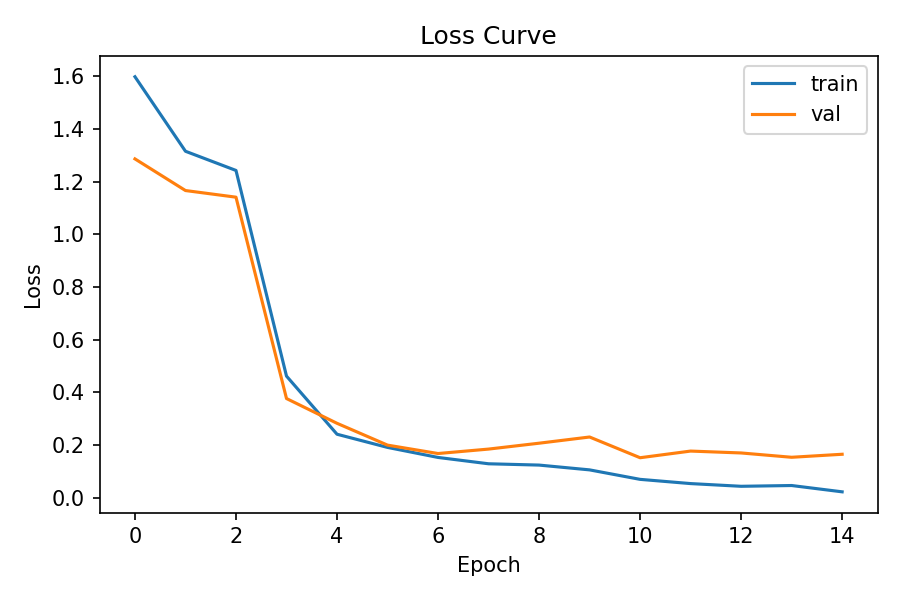

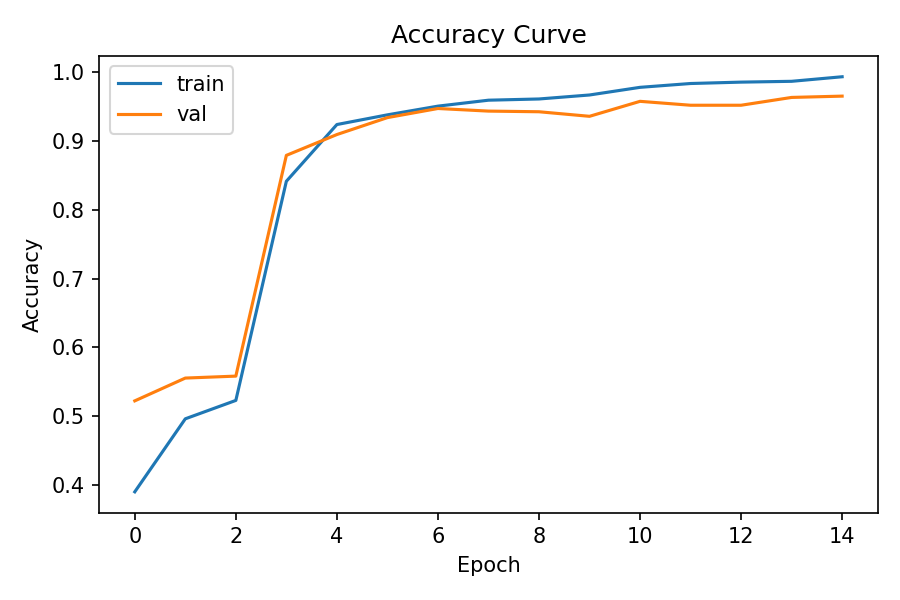

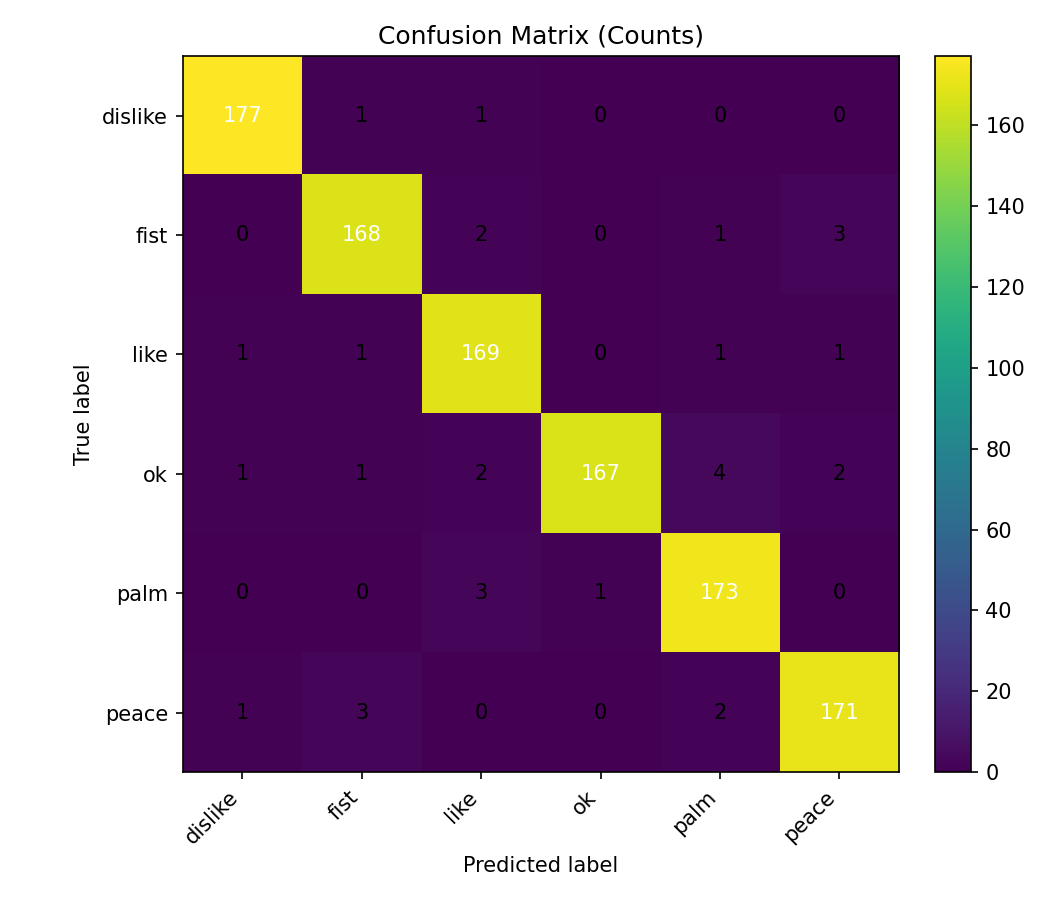

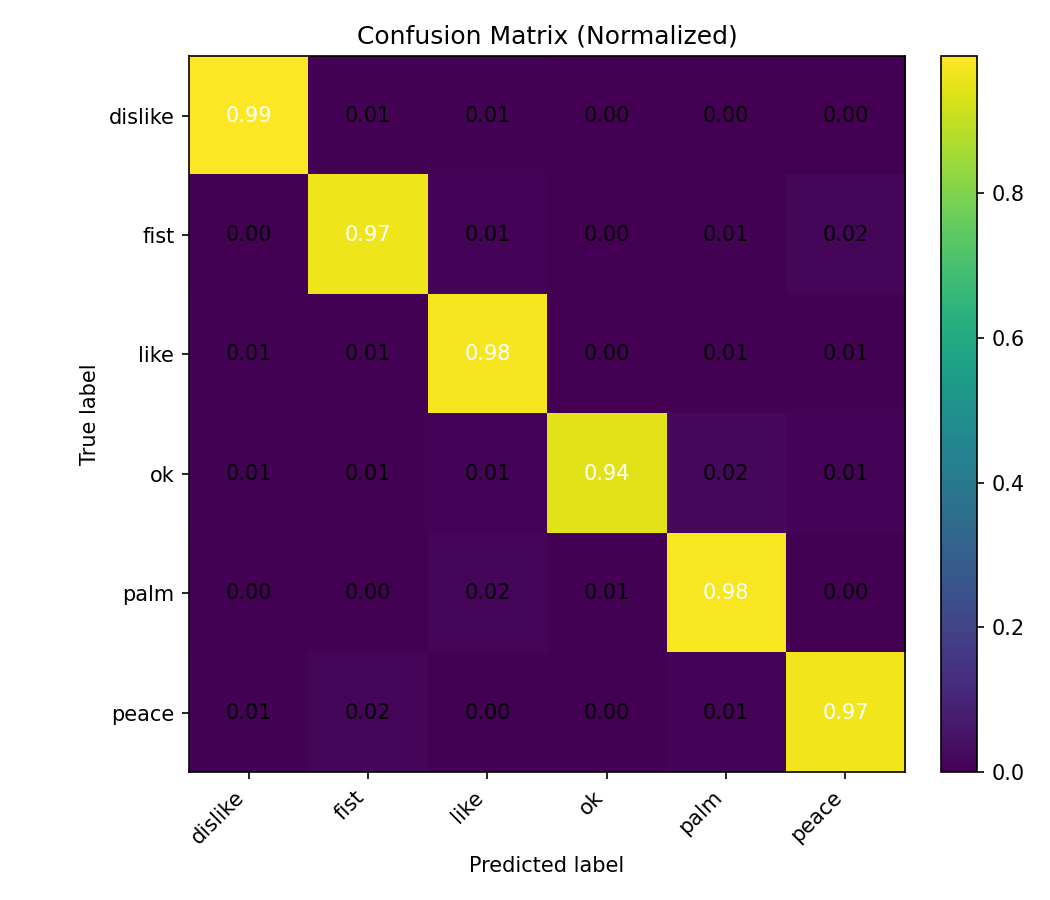

In [ ]:
# แสดงไฟล์ที่ถูกเซฟ
from pathlib import Path
print("OUT_DIR =", OUT_DIR.resolve())
for p in sorted(Path(OUT_DIR).glob("*")):
    print(p.name)

# แสดงกราฟ loss/acc inline
from IPython.display import Image, display
display(Image(filename=str(OUT_DIR/"loss_curve.png")))
display(Image(filename=str(OUT_DIR/"acc_curve.png")))

# ถ้ายังอยากดู confusion matrix inline (ไฟล์ก็ถูกเซฟไปแล้ว)
display(Image(filename=str(OUT_DIR/"cm_test_counts.png")))
display(Image(filename=str(OUT_DIR/"cm_test_norm.png")))


# Test

In [ ]:
# ==== Rehydrate everything for evaluation ====
import os, json, torch
from pathlib import Path

# --- 1) Config fallback (ถ้าตัวแปรพวกนี้ยังไม่มี) ---
try: OUT_DIR
except NameError: OUT_DIR = Path("/content/run_outputs")
try: DATA_ROOT
except NameError: DATA_ROOT = Path("/content/splits_local")
try: IMG_SIZE
except NameError: IMG_SIZE = 224
try: BATCH
except NameError: BATCH = 32
try: NUM_WORKERS
except NameError: NUM_WORKERS = min(2, os.cpu_count() or 2)

# --- 2) Device ---
def device_default():
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = device_default()
print("device =", device)

# --- 3) Classes ---
cls_json = OUT_DIR/"classes.json"
if cls_json.exists():
    with open(cls_json, "r") as f:
        classes = json.load(f)["classes"]
else:
    classes = ['dislike', 'fist', 'like', 'ok', 'palm', 'peace']
print("classes:", classes)

# --- 4) Minimal transforms & dataloaders (ถ้ายังไม่มีฟังก์ชัน) ---
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def _build_transforms(img_size=224):
    mean=(0.485,0.456,0.406); std=(0.229,0.224,0.225)
    eval_tf = transforms.Compose([
        transforms.Resize(int(img_size*1.15)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean,std),
    ])
    train_tf = transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.7,1.0)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ColorJitter(0.1,0.1,0.1,0.05),
        transforms.ToTensor(),
        transforms.Normalize(mean,std),
    ])
    return train_tf, eval_tf

def _build_dls(data_root: Path, img_size=224, batch_size=32, num_workers=2):
    train_tf, eval_tf = _build_transforms(img_size)
    train_ds = datasets.ImageFolder(data_root/"train", transform=train_tf)
    val_ds   = datasets.ImageFolder(data_root/"val",   transform=eval_tf)
    test_ds  = datasets.ImageFolder(data_root/"test",  transform=eval_tf)
    dls = {
        "train": DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True, persistent_workers=True),
        "val":   DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True),
        "test":  DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True),
    }
    return dls, train_ds.classes

dls, _classes = _build_dls(DATA_ROOT, IMG_SIZE, BATCH, NUM_WORKERS)
# ถ้า classes จากไฟล์/ด้านบนไม่ตรงกับ dataset ให้ใช้ของ dataset
if _classes and _classes != classes:
    classes = _classes
print("DataLoaders ready.")

# --- 5) Model (load from best.pt ถ้าไม่มีในหน่วยความจำ) ---
try:
    _ = model
    model.eval().to(device)
    print("Using in-memory model.")
except NameError:
    # ต้องมีฟังก์ชัน build_model ตามที่ใช้เทรน ถ้าไม่มี ให้ import/นิยามสั้น ๆ
    import torch.nn as nn
    from torchvision import models

    # โมเดลหัวคัสตอมแบบย่อ (ให้ตรงกับที่ใช้เทรน)
    class ConvBNAct(nn.Module):
        def __init__(self, c_in, c_out, k=3, s=1, p=1):
            super().__init__()
            self.conv=nn.Conv2d(c_in,c_out,k,s,p,bias=False); self.bn=nn.BatchNorm2d(c_out); self.act=nn.ReLU(inplace=True)
        def forward(self,x): return self.act(self.bn(self.conv(x)))
    class SEBlock(nn.Module):
        def __init__(self, ch, r=16):
            super().__init__()
            self.pool=nn.AdaptiveAvgPool2d(1)
            self.fc=nn.Sequential(nn.Conv2d(ch,ch//r,1), nn.ReLU(inplace=True), nn.Conv2d(ch,ch,1), nn.Sigmoid())
        def forward(self,x): return x*self.fc(self.pool(x))
    class GestureHead(nn.Module):
        def __init__(self, in_ch=512, mid_ch=256, num_classes=6, drop_p=0.2):
            super().__init__()
            self.neck=nn.Sequential(ConvBNAct(in_ch, mid_ch,3,1,1), SEBlock(mid_ch,16))
            self.pool=nn.AdaptiveAvgPool2d(1); self.drop=nn.Dropout(drop_p); self.fc=nn.Linear(mid_ch, num_classes)
        def forward(self,x):
            x=self.neck(x); x=self.pool(x).flatten(1); x=self.drop(x); return self.fc(x)
    class GestureResNet18Custom(nn.Module):
        def __init__(self, num_classes, use_pretrained=False, mid_ch=256, drop_p=0.2):
            super().__init__()
            base = models.resnet18(weights=None)  # ไม่โหลด weights ตอนรีบิลด์เพื่อความเร็ว
            self.backbone=nn.Sequential(base.conv1, base.bn1, base.relu, base.maxpool, base.layer1, base.layer2, base.layer3, base.layer4)
            self.head=GestureHead(512, mid_ch, num_classes, drop_p)
        def forward(self,x): return self.head(self.backbone(x))
    def build_model(num_classes, use_pretrained=False, mid_ch=256, drop_p=0.2):
        return GestureResNet18Custom(num_classes, use_pretrained, mid_ch, drop_p)

    model = build_model(num_classes=len(classes), use_pretrained=False, mid_ch=256, drop_p=0.2)
    state = torch.load(OUT_DIR/"best.pt", map_location="cpu")
    model.load_state_dict(state["state_dict"], strict=True)
    model.to(device).eval()
    print("Model loaded from best.pt")


device = cuda
classes: ['dislike', 'fist', 'like', 'ok', 'palm', 'peace']
DataLoaders ready.
Using in-memory model.


In [ ]:
# ==== FIX INFERENCE MODEL SHAPE (run me once) ====
import torch, json
from pathlib import Path
from torchvision import models
import torch.nn as nn

OUT_DIR = Path("/content/run_outputs")   # แก้ให้ตรงโปรเจกต์ถ้าจำเป็น
ckpt = torch.load(OUT_DIR/"best.pt", map_location="cpu")["state_dict"]

# --- อ่านค่าจาก checkpoint เพื่อตรวจว่าเทรนด้วย mid_ch เท่าไร และ r เท่าไร ---
w = ckpt.get("head.neck.1.fc.0.weight")  # weight ของ conv1 ใน SEBlock: shape = [ch//r, ch, 1, 1]
assert w is not None, "ไม่พบพารามิเตอร์ SEBlock ใน checkpoint"
ch_div_r, ch = w.shape[:2]               # out_channels = ch//r, in_channels = ch
mid_ch_from_ckpt = int(ch)
r_from_ckpt = int(ch // ch_div_r)
print(f"[CKPT] mid_ch={mid_ch_from_ckpt}, r={r_from_ckpt}")

# --- นิยามโมเดลให้ตรงกับตอนเทรน ---
class ConvBNAct(nn.Module):
    def __init__(self, c_in, c_out, k=3, s=1, p=1, act=True):
        super().__init__()
        self.conv = nn.Conv2d(c_in, c_out, k, s, p, bias=False)
        self.bn   = nn.BatchNorm2d(c_out)
        self.act  = nn.ReLU(inplace=True) if act else nn.Identity()
    def forward(self, x): return self.act(self.bn(self.conv(x)))

class SEBlock(nn.Module):
    def __init__(self, ch, r=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc   = nn.Sequential(
            nn.Conv2d(ch, ch // r, 1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch // r, ch, 1, bias=True),
            nn.Sigmoid()
        )
    def forward(self, x):
        w = self.fc(self.pool(x))
        return x * w

class GestureHead(nn.Module):
    def __init__(self, in_ch=512, mid_ch=256, num_classes=6, drop_p=0.2, r=16):
        super().__init__()
        self.neck = nn.Sequential(
            ConvBNAct(in_ch, mid_ch, k=3, s=1, p=1),
            SEBlock(mid_ch, r=r),
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.drop = nn.Dropout(p=drop_p)
        self.fc   = nn.Linear(mid_ch, num_classes)
    def forward(self, x):
        x = self.neck(x)
        x = self.pool(x).flatten(1)
        x = self.drop(x)
        return self.fc(x)

class GestureResNet18Custom(nn.Module):
    def __init__(self, num_classes, use_pretrained=False, mid_ch=256, drop_p=0.2, r=16):
        super().__init__()
        base = models.resnet18(weights=None)  # ไม่ต้องโหลด weights สำหรับสร้างโครง
        self.backbone = nn.Sequential(
            base.conv1, base.bn1, base.relu, base.maxpool,
            base.layer1, base.layer2, base.layer3, base.layer4
        )
        self.head = GestureHead(in_ch=512, mid_ch=mid_ch, num_classes=num_classes, drop_p=drop_p, r=r)
    def forward(self, x):
        return self.head(self.backbone(x))

# --- โหลด classes เพื่อรู้จำนวนคลาส ---
cls_json = OUT_DIR/"classes.json"
if cls_json.exists():
    with open(cls_json,"r") as f: classes = json.load(f)["classes"]
else:
    classes = ['dislike','fist','like','ok','palm','peace']
num_classes = len(classes)

# --- สร้างโมเดลให้ "ตรงกับ checkpoint" แล้วค่อยโหลด state_dict ---
model = GestureResNet18Custom(num_classes=num_classes, use_pretrained=False,
                              mid_ch=mid_ch_from_ckpt, drop_p=0.2, r=r_from_ckpt)
missing, unexpected = model.load_state_dict(ckpt, strict=False)
print("load_state_dict:", "OK" if not missing and not unexpected else f"missing={missing}, unexpected={unexpected}")

# --- ส่งขึ้น GPU + eval ---
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device).eval()
print("Device:", device)

# --- ฟังก์ชันพยากรณ์ (ใช้ eval_tf ที่คุณนิยามไว้) ---
from PIL import Image
from torchvision import transforms
IMG_SIZE = 224
eval_tf = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])

@torch.no_grad()
def predict_image(img_path, topk=3):
    img = Image.open(img_path).convert("RGB")
    x = eval_tf(img).unsqueeze(0).to(device)
    try:
        ctx = torch.amp.autocast("cuda", enabled=(device.type=="cuda"))
    except Exception:
        ctx = torch.cuda.amp.autocast(enabled=(device.type=="cuda"))
    with ctx:
        logits = model(x)
        probs = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()
    top = probs.argsort()[::-1][:topk]
    return img, [(classes[i], float(probs[i])) for i in top], probs


[CKPT] mid_ch=256, r=16
load_state_dict: OK
Device: cuda


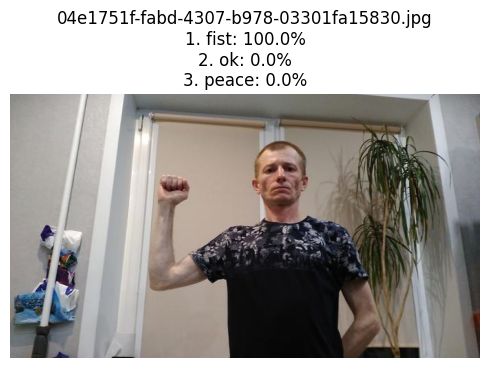

Top-k: [('fist', 0.9997066855430603), ('ok', 0.00014636678679380566), ('peace', 9.404118463862687e-05)]


In [ ]:
test_img_path = "/content/splits_local/test/fist/04e1751f-fabd-4307-b978-03301fa15830.jpg"  # เปลี่ยนเป็นรูปของคุณ
img, top_list, probs = predict_image(test_img_path, topk=3)
show_prediction(img, top_list, title=Path(test_img_path).name)
print("Top-k:", top_list)


ตาราง per-class + กราฟแท่ง

,class,precision,recall,f1,support
0,dislike,0.983333,0.988827,0.986072,179
3,ok,0.994048,0.943503,0.968116,177
4,palm,0.955801,0.977401,0.966480,177
5,peace,0.966102,0.966102,0.966102,177
2,like,0.954802,0.976879,0.965714,173
1,fist,0.965517,0.965517,0.965517,174


(0.0, 1.05)

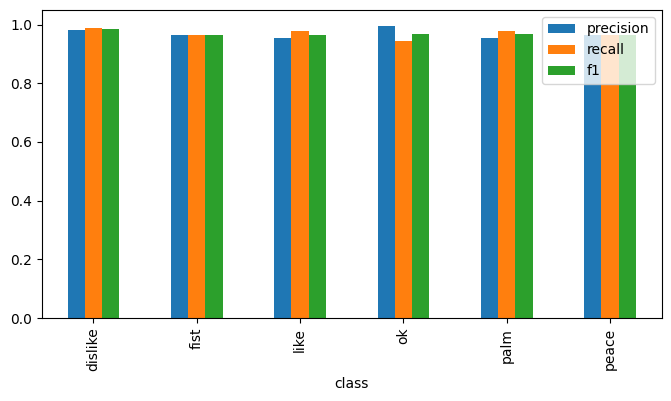

In [ ]:
import numpy as np, pandas as pd
from sklearn.metrics import precision_recall_fscore_support

acc, y_true, y_pred, logits = run_eval(model, dls["test"], device)
p, r, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0)
df = pd.DataFrame({"class": classes, "precision":p, "recall":r, "f1":f1, "support":support})
display(df.sort_values("f1", ascending=False).style.background_gradient(cmap="Greens"))
ax = df.set_index("class")[["precision","recall","f1"]].plot(kind="bar", figsize=(8,4)); ax.set_ylim(0,1.05)


PR Curves + mAP (วัดความทนต่อ threshold)

Macro Average Precision (PR AUC): 0.9942


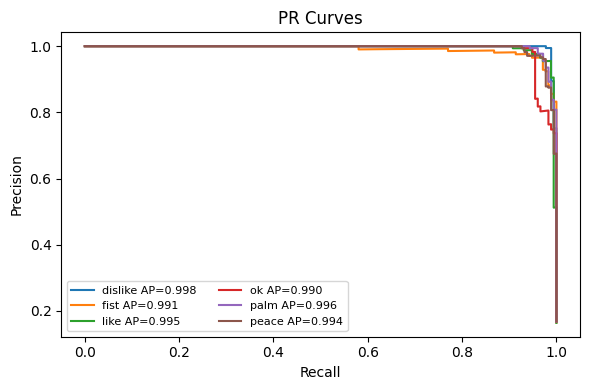

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt, torch, numpy as np

probs = torch.softmax(torch.from_numpy(logits), dim=1).numpy()
Y = label_binarize(y_true, classes=list(range(len(classes))))
AP = [average_precision_score(Y[:,k], probs[:,k]) for k in range(len(classes))]
print("Macro Average Precision (PR AUC):", np.mean(AP).round(4))

plt.figure(figsize=(6,4))
for k in range(len(classes)):
    pr, rc, _ = precision_recall_curve(Y[:,k], probs[:,k])
    plt.plot(rc, pr, label=f"{classes[k]} AP={AP[k]:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(ncol=2, fontsize=8); plt.title("PR Curves")
plt.tight_layout(); plt.show()


แกลเลอรี “รูปที่ทายผิด” + ความมั่นใจ

Misclassified: 32


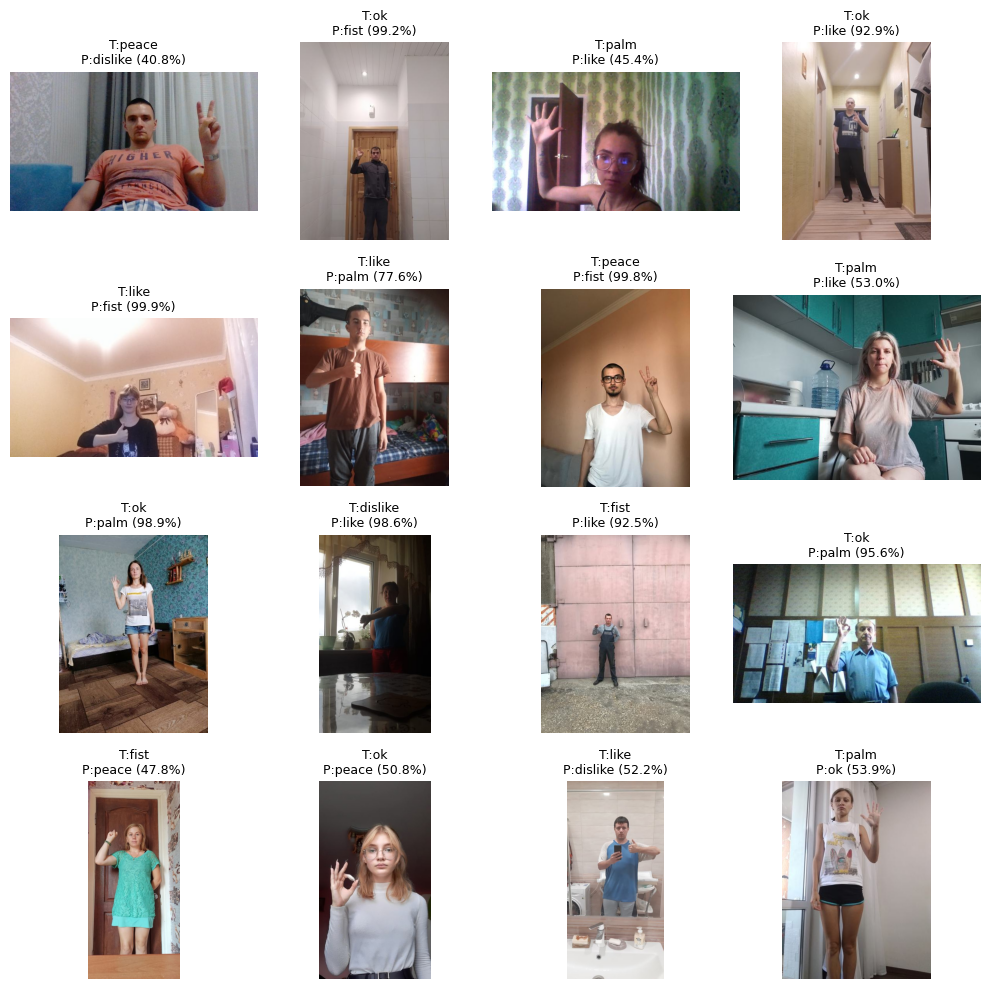

In [ ]:
import random, matplotlib.pyplot as plt
from torchvision.utils import make_grid
from PIL import Image

# เอา index ที่ผิด
wrong_idx = np.where(y_true != y_pred)[0]
print("Misclassified:", len(wrong_idx))
sample = wrong_idx if len(wrong_idx) <= 16 else np.random.choice(wrong_idx, 16, replace=False)

_, eval_tf = build_transforms(IMG_SIZE)
fig, axes = plt.subplots(4,4, figsize=(10,10))
for ax, idx in zip(axes.ravel(), sample):
    # ดึงไฟล์ภาพจาก test dataset
    img_path, true_label = dls["test"].dataset.samples[idx]
    img = Image.open(img_path).convert("RGB")
    # คะแนนความมั่นใจของคลาสที่โมเดลทาย
    conf = torch.softmax(torch.from_numpy(logits[idx]), dim=0).max().item()
    ax.imshow(img); ax.axis("off")
    ax.set_title(f"T:{classes[y_true[idx]]}\nP:{classes[y_pred[idx]]} ({conf*100:.1f}%)", fontsize=9)
plt.tight_layout(); plt.show()
